In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.io import fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [4]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

In [5]:
joj_bino = np.loadtxt('./data/ZTF22aajijjf_20230314_Binospec.ascii')
joj_lris = np.loadtxt('./data/ZTF22aajijjf_20230426_LRIS.ascii')
for joj in [joj_bino, joj_lris]:
    joj[:, 1] = joj[:, 1] * 10**(0.4 * calALambda(joj[:, 0], RV=3.1, EBV=0.04))
    joj[:, 2] = joj[:, 2] * 10**(0.4 * calALambda(joj[:, 0], RV=3.1, EBV=0.04))

joj_bino_bin = data_binning(joj_bino, size=5)
joj_lris_bin = data_binning(joj_lris, size=5)

z = 0.02736
MJD_peak = 59722.75
MJD_bino = 60017.42217
MJD_lris = 60061.559493
phase_bino, phase_lris = (np.array([MJD_bino, MJD_lris]) - MJD_peak) / (1 + z)
phase_bino, phase_lris

(286.8246476405525, 329.7865334449469)

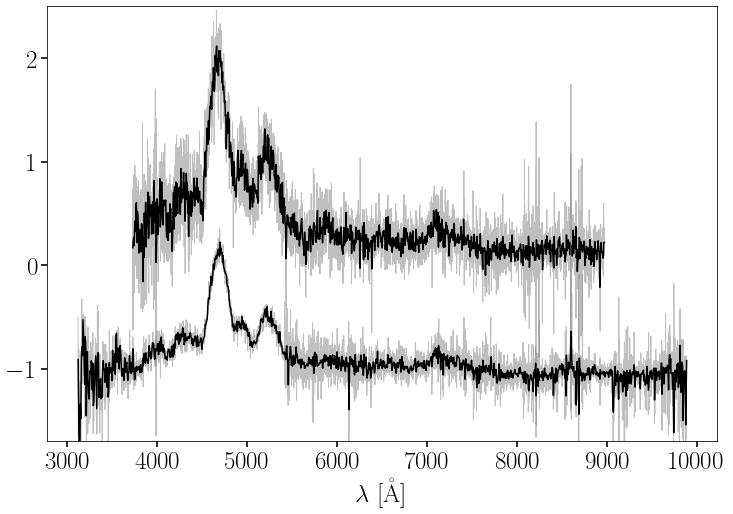

In [6]:
plt.figure(figsize=(12, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * 1.2, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * 1.2, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-1.7, 2.5)
plt.show()

# Fit line velocities

In [6]:
from absorption_line_vel import SpectrumSN_Lines

# read spec data
z = 0.02736  # redshift
Spec_bino = SpectrumSN_Lines("./data/ZTF22aajijjf_20230314_Binospec.ascii", z, bin=True, bin_size=10,)
Spec_lris = SpectrumSN_Lines("./data/ZTF22aajijjf_20230426_LRIS.ascii", z, bin=True, bin_size=10,)

## [Co iii] 6000

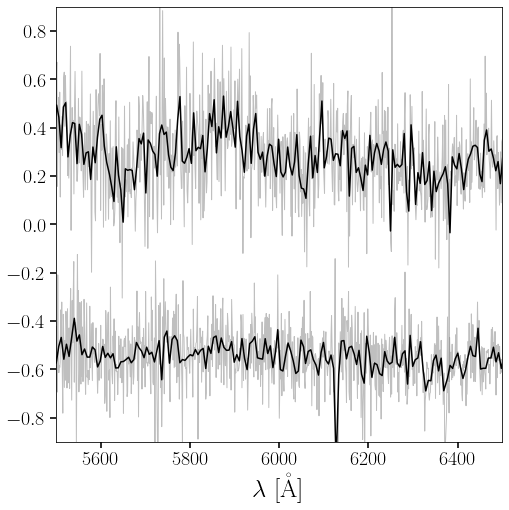

In [8]:
plt.figure(figsize=(8, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * .8, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * .8, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-.9, .9)
# plt.axvline(6564.6, color='k')
# plt.axvline(6716.440 + 2, color='k')
plt.xlim(5500, 6500)
plt.show()

binning spectrum...
LS estimation:
Velocity 1: -847 km/s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.6816, but should be close to 0.8. Try to increase the number of tuning steps.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0]  -690.338  556.883 -1182.646   -95.825     12.485    9.000   
v_sig[0]   3181.629  726.716  2460.667  3894.060     18.354   13.174   
A[0]        859.450  236.702   591.379  1048.956      6.517    4.753   
sigma_0       0.102    0.029     0.075     0.132      0.001    0.000   
EW_0       -125.929   40.973  -155.230   -80.069      1.150    0.841   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2003.113  2312.261  1.001  
v_sig[0]   1600.351  1953.483  1.003  
A[0]       1388.072  1610.737  1.003  
sigma_0    1854.054   998.470  1.000  
EW_0       1378.269  1348.738  1.003  


(-1.0, 2.1)

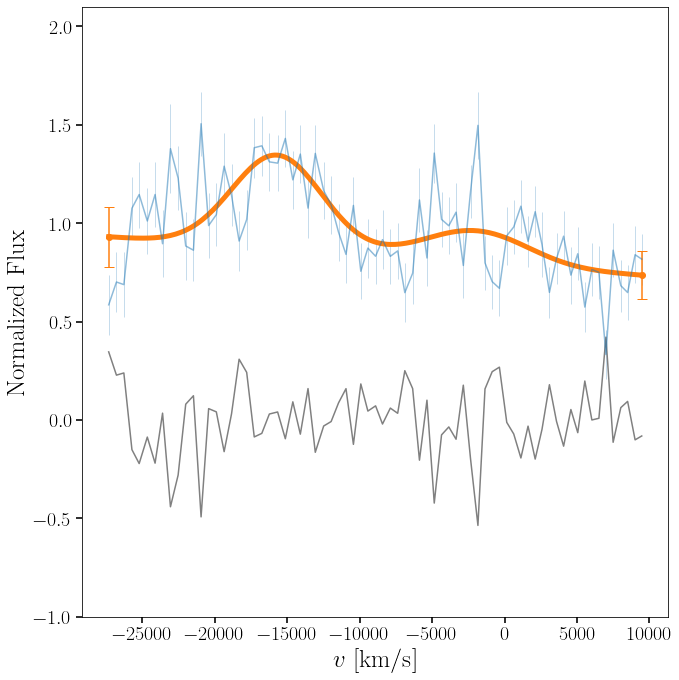

In [9]:
Spec_bino.add_line(
    "[CoIII]",
    5650,
    6400,
    lines=[[5888.48, 5906.78, 6195.45, 6127.67]],
    rel_strength=[[12.6e3, 3.82e3, 3.78e3, 2.71e3]],
)  # Table 9, Storey & Sochi 2016
Spec_bino.line["[CoIII]"].LS_estimator(guess=(1, 1, -1000, 15, 1000))
_, _, ax = Spec_bino.line["[CoIII]"].MCMC_sampler(vel_mean_mu=[0], vel_mean_sig=[1e3])
ax.set_ylim(-1, 2.1)

## [Fe ii] 7300

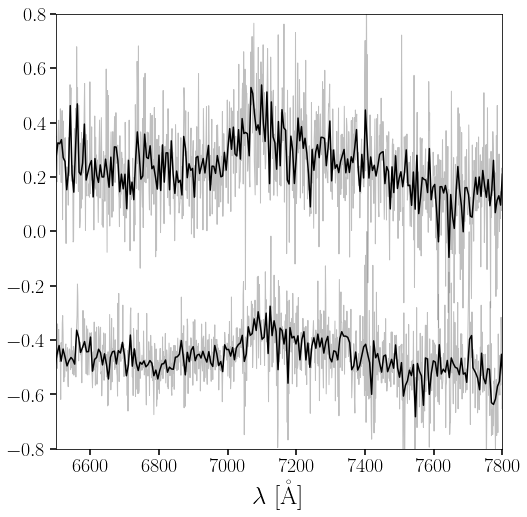

In [8]:
plt.figure(figsize=(8, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * .7, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * .7, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-.8, .8)
# plt.axvline(6564.6, color='k')
# plt.axvline(6716.440 + 2, color='k')
plt.xlim(6500, 7800)
plt.show()

binning spectrum...
LS estimation:
Velocity 1: -10358 km/s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


               mean        sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -4495.704  1108.231 -5616.979 -3444.035     31.041   22.528   
v_sig[0]   8637.331   957.378  8265.783  9996.190     26.919   19.039   
A[0]       1829.829   357.290  1429.124  2142.700      9.534    6.743   
sigma_0       0.123     0.022     0.101     0.145      0.001    0.000   
EW_0       -271.348    65.038  -324.338  -197.570      1.753    1.240   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  1272.760  1315.489  1.001  
v_sig[0]   1254.144  1842.198  1.001  
A[0]       1404.642  1998.286  1.003  
sigma_0    1757.273  1354.719  1.000  
EW_0       1374.088  1908.490  1.002  


(-0.5, 1.6)

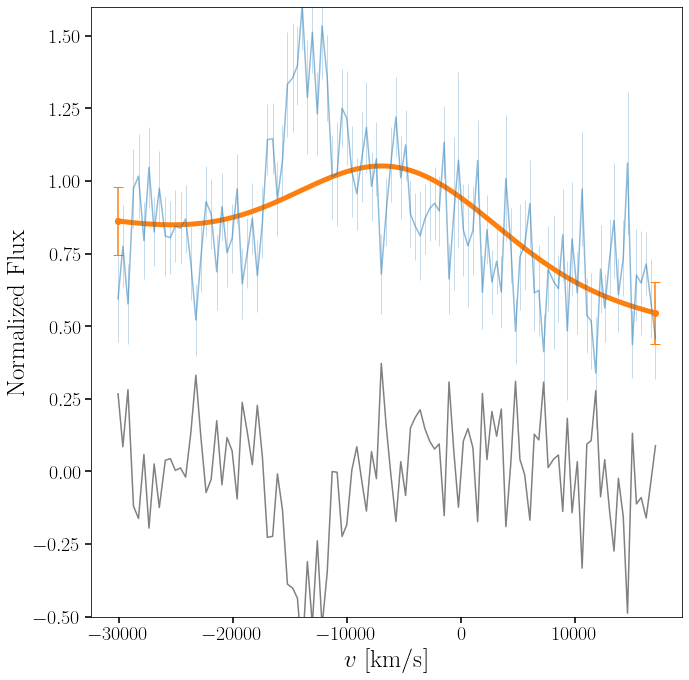

In [11]:
Spec_bino.add_line(
    "[NiII]_7300",
    6700,
    7850,
    lines=[[7378, 7412]],
    rel_strength=[[1, 0.31]],
)  # Jerkstrand et al. 2015, 2015MNRAS.448.2482J
Spec_bino.line["[NiII]_7300"].LS_estimator(guess=(1, 1, -1000, 15, 1000))
_, _, ax = Spec_bino.line["[NiII]_7300"].MCMC_sampler(
    vel_mean_mu=[-1e3], vel_mean_sig=[1e3]
)
ax.set_ylim(-.5, 1.6)

binning spectrum...
LS estimation:
Velocity 1: -2376 km/s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -2223.985  326.395 -2578.557 -1943.444      6.094    4.309   
v_sig[0]   3204.024  339.426  2830.568  3480.547      7.438    5.325   
A[0]       1230.465  125.168  1119.555  1370.395      2.740    1.938   
sigma_0       0.044    0.024     0.018     0.070      0.001    0.000   
EW_0       -234.280   29.028  -263.263  -205.778      0.644    0.456   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3062.309  2058.731  1.001  
v_sig[0]   2148.735  2107.726  1.001  
A[0]       2082.683  2102.781  1.001  
sigma_0    1738.488  1335.208  1.003  
EW_0       2024.697  2170.474  1.002  


(-0.5, 1.7)

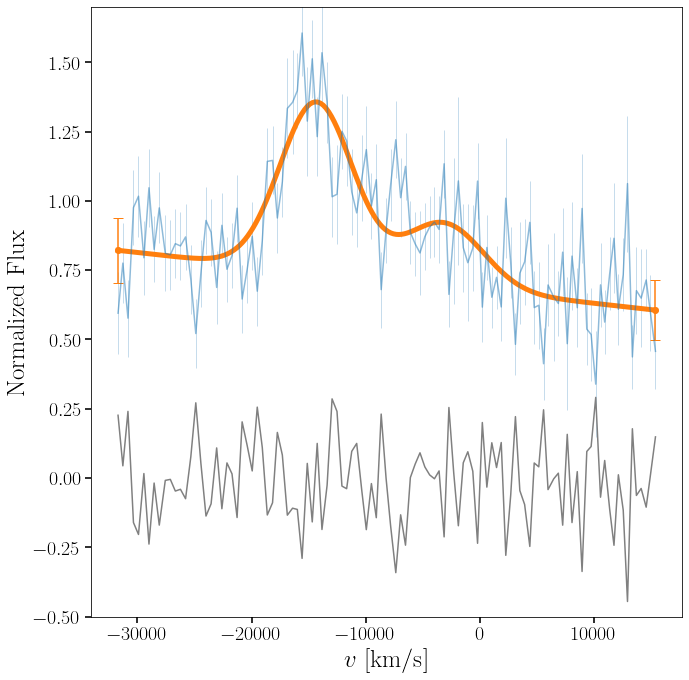

In [12]:
Spec_bino.add_line(
    "[FeII]_7300",
    6700,
    7850,
    lines=[[7155, 7172, 7388, 7453]],
    rel_strength=[[1, 0.24, 0.19, 0.31]],
)  # Jerkstrand et al. 2015, 2015MNRAS.448.2482J
Spec_bino.line["[FeII]_7300"].LS_estimator(guess=(1, 1, -1000, 15, 1000))
_, _, ax = Spec_bino.line["[FeII]_7300"].MCMC_sampler(
    vel_mean_mu=[-1e3], vel_mean_sig=[1e3]
)
ax.set_ylim(-0.5, 1.7)

binning spectrum...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 40 seconds.


               mean        sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -2461.784   377.533 -2829.257 -2115.420      9.559    6.837   
v_mean[1] -2894.247  2596.494 -5942.996  -852.085     82.457   61.265   
v_sig[0]   2982.648   470.891  2513.876  3411.790     14.852   10.505   
v_sig[1]   3021.352  1452.214  1002.016  3766.759     33.723   24.458   
A[0]       1169.780   195.403  1003.480  1376.565      6.386    4.517   
A[1]        129.492   173.660   -26.164   271.215      5.973    4.258   
sigma_0       0.041     0.025     0.005     0.057      0.001    0.000   
EW_0       -224.480    43.276  -263.899  -183.035      1.360    0.962   
EW_1        -18.682    24.894   -38.424     4.299      0.847    0.600   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  1561.904  1849.039  1.002  
v_mean[1]   986.206  1192.115  1.001  
v_sig[0]   1000.613  1274.566  1.002  
v_sig[1]   1865.349  2002.106  1.004  
A[0]        960.169  1066.724  1.001  
A[1]        895.413  1229.203  1.00

(-0.5, 1.7)

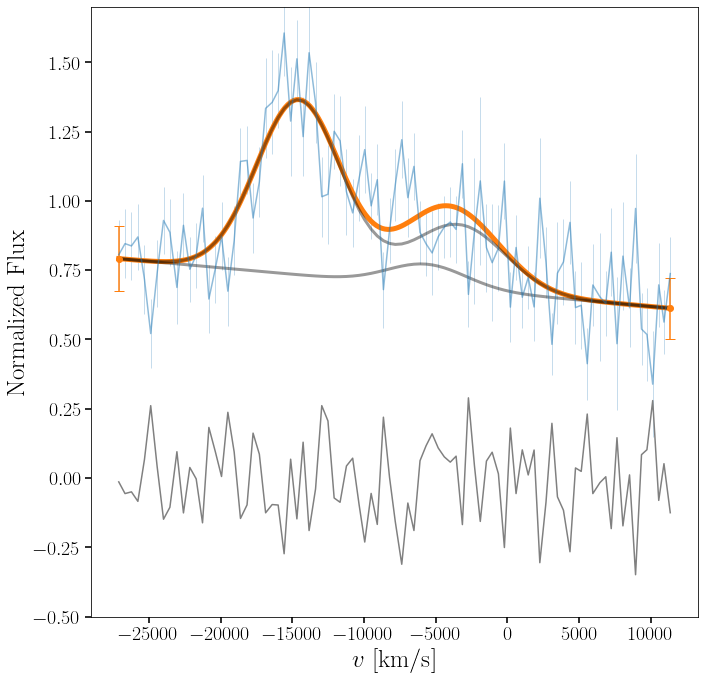

In [24]:
Spec_bino.add_line(
    "[FeII/NiII]_7300",
    6800,
    7750,
    lines=[[7155, 7172, 7388, 7453], [7378, 7412]],
    rel_strength=[[1, 0.24, 0.19, 0.31], [1, 0.31]],
)
_, _, ax = Spec_bino.line["[FeII/NiII]_7300"].MCMC_sampler(
    vel_mean_mu=[-1e3, -1e3],
    vel_mean_sig=[2e3, 2e3],
    vel_var_lim=[1e3**2, 6e3**2],
    initial=(1, 1, -1500, 15, 1000, -1000, 15, 1000),
    nburn=10000,
    A_lim=[-1e3, 1e4],
)
ax.set_ylim(-.5, 1.7)

In [32]:
print("pEW [Fe II]", np.array([-224.480, 43.276]) / (1 + 0.24 + 0.19 + 0.31))
print("pEW [Ni II]", np.array([-18.682, 24.894]) / (1 + 0.31))

pEW [Fe II] [-129.01149425   24.87126437]
pEW [Ni II] [-14.2610687   19.00305344]


In [25]:
post = Spec_bino.line["[FeII/NiII]_7300"].trace.posterior
EW_ratio = (
    post["EW_1"].values.ravel()
    / post["EW_0"].values.ravel()
    / ((1 + 0.31) / (1 + 0.24 + 0.19 + 0.31))
)

from astropy.stats import mad_std

np.mean(EW_ratio), mad_std(EW_ratio), np.std(EW_ratio, ddof=1)

(0.13436287808885786, 0.1378569617767244, 0.2073567108154968)

(0.005941382451344694, 0.008498158171875141, 0.013844156856562368)

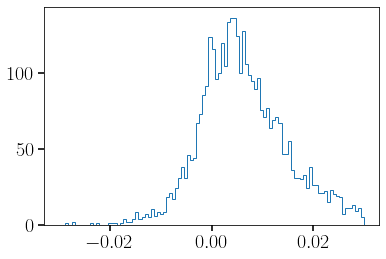

In [26]:
# tentative calculation of n(Ni)/n(Fe)
# Jerkstrand et al. 2015, 2015MNRAS.448.2482J

post = Spec_bino.line["[FeII/NiII]_7300"].trace.posterior
EW_ratio = post['EW_1'].values.ravel()/post['EW_0'].values.ravel()

L_ratio = EW_ratio.ravel() / ((1 + 0.31) / (1 + 0.24 + 0.19 + 0.31))
N = len(L_ratio)
T = np.random.rand(N) * 5000 + 3000 # electron temperature
dc = np.random.rand(N) * 1.2 + 1.2 # departure coefficient ratio
xi = np.random.rand(N) * 0.4 + 0.8 # ionization balance
k_B = 8.61733326e-5
n_ratio = L_ratio / 4.9 / dc * np.exp(-0.28 / (k_B * T)) * xi
_ = plt.hist(n_ratio, histtype="step", bins=100, range=(-0.03, 0.03))
np.median(n_ratio), mad_std(n_ratio), np.std(n_ratio, ddof=1)

binning spectrum...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21 seconds.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -1255.130  417.462 -1693.599  -875.331      7.176    5.168   
v_sig[0]   4678.552  607.195  3977.398  5124.025     16.380   12.086   
A[0]       1507.862  148.991  1344.117  1624.720      3.902    2.845   
sigma_0       0.068    0.018     0.052     0.086      0.000    0.000   
EW_0       -250.028   30.985  -274.278  -216.626      0.828    0.606   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3372.114  2882.255  1.002  
v_sig[0]   1617.147  1504.504  1.001  
A[0]       1591.034  1644.450  1.000  
sigma_0    1955.884   782.141  1.001  
EW_0       1556.470  1657.165  1.000  


(-1.0, 2.1)

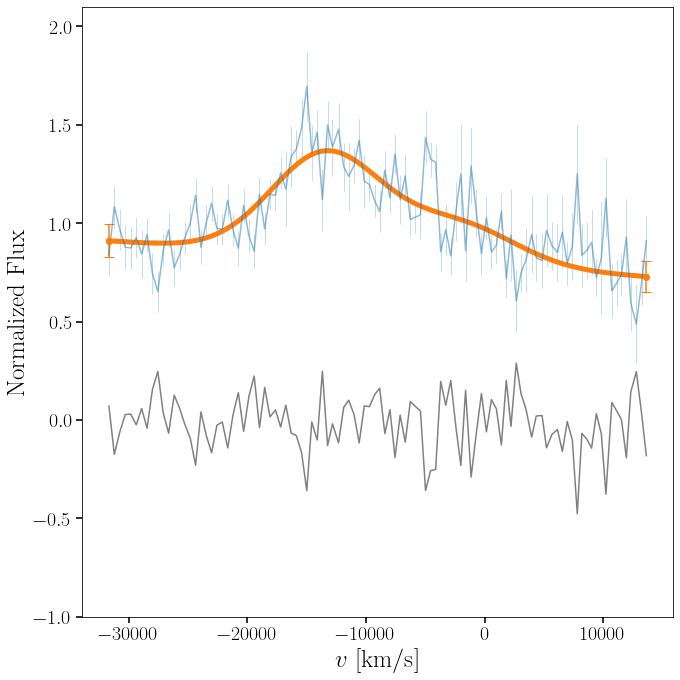

In [16]:
Spec_lris.add_line(
    "[FeII]_7300",
    6700,
    7800,
    lines=[[7155, 7172, 7388, 7453]],
    rel_strength=[[1, 0.24, 0.19, 0.31]],
)  # Jerkstrand et al. 2015
_, _, ax = Spec_lris.line["[FeII]_7300"].MCMC_sampler(
    vel_mean_mu=[-1e3], vel_mean_sig=[1e3], initial=(1, 1, -1000, 15, 1000)
)
ax.set_ylim(-1, 2.1)

binning spectrum...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 44 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6585, but should be close to 0.8. Try to increase the number of tuning steps.


               mean        sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -1555.846   602.882 -2239.672 -1089.140     18.396   13.272   
v_mean[1] -2491.492  2437.793 -5498.015 -1013.456     83.081   58.803   
v_sig[0]   3835.113   797.032  2951.734  4521.114     30.924   22.054   
v_sig[1]   3107.735  1418.484  1001.443  3841.835     36.223   25.867   
A[0]       1221.236   273.788   985.708  1493.310     10.717    7.581   
A[1]        148.644   236.556   -61.329   327.841      9.495    6.717   
sigma_0       0.067     0.019     0.050     0.085      0.001    0.001   
EW_0       -196.052    48.585  -240.015  -150.376      1.857    1.313   
EW_1        -17.676    28.178   -38.616     7.852      1.128    0.798   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  1069.519  1620.753  1.002  
v_mean[1]   837.757  1127.991  1.001  
v_sig[0]    665.567   713.546  1.008  
v_sig[1]   1464.572  1352.276  1.001  
A[0]        666.135   927.392  1.006  
A[1]        656.887   853.884  1.00

(-1.0, 2.1)

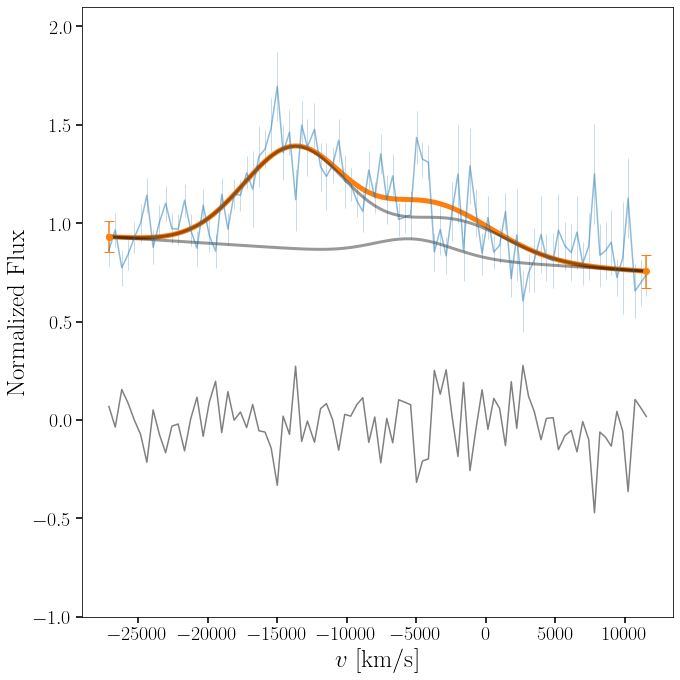

In [27]:
Spec_lris.add_line(
    "[FeII/NiII]_7300",
    6800,
    7750,
    lines=[[7155, 7172, 7388, 7453], [7378, 7412]],
    rel_strength=[[1, 0.24, 0.19, 0.31], [1, 0.31]],
)
_, _, ax = Spec_lris.line["[FeII/NiII]_7300"].MCMC_sampler(
    vel_mean_mu=[-1e3, -1e3],
    vel_mean_sig=[2e3, 2e3],
    vel_var_lim=[1e3**2, 6e3**2],
    initial=(1, 1, -1500, 15, 1000, -1000, 15, 1000),
    nburn=10000,
    A_lim=[-1e3, 1e4],
)
ax.set_ylim(-1, 2.1)

In [33]:
print("pEW [Fe II]", np.array([-196.052, 48.585]) / (1 + 0.24 + 0.19 + 0.31))
print("pEW [Ni II]", np.array([-17.676, 28.178]) / (1 + 0.31))

pEW [Fe II] [-112.67356322   27.92241379]
pEW [Ni II] [-13.49312977  21.50992366]


In [28]:
post = Spec_lris.line["[FeII/NiII]_7300"].trace.posterior
EW_ratio = (
    post["EW_1"].values.ravel()
    / post["EW_0"].values.ravel()
    / ((1 + 0.31) / (1 + 0.24 + 0.19 + 0.31))
)

from astropy.stats import mad_std

np.mean(EW_ratio), mad_std(EW_ratio), np.std(EW_ratio, ddof=1)

(0.17979130249371283, 0.16445878614697956, 0.3455062731527289)

(0.006238226244685919, 0.010022028711205107, 0.022125909673308884)

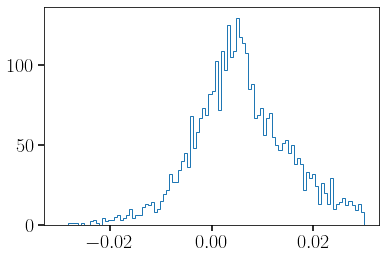

In [29]:
# tentative calculation of n(Ni)/n(Fe)
# Jerkstrand et al. 2015, 2015MNRAS.448.2482J

post = Spec_lris.line["[FeII/NiII]_7300"].trace.posterior
EW_ratio = post["EW_1"].values.ravel() / post["EW_0"].values.ravel()

L_ratio = EW_ratio.ravel() / ((1 + 0.31) / (1 + 0.24 + 0.19 + 0.31))
N = len(L_ratio)
T = np.random.rand(N) * 5000 + 3000 # electron temperature
dc = np.random.rand(N) * 1.2 + 1.2 # departure coefficient ratio
xi = np.random.rand(N) * 0.4 + 0.8 # ionization balance
k_B = 8.61733326e-5
n_ratio = L_ratio / 4.9 / dc * np.exp(-0.28 / (k_B * T)) * xi
_ = plt.hist(n_ratio, histtype="step", bins=100, range=(-0.03, 0.03))
np.median(n_ratio), mad_std(n_ratio), np.std(n_ratio, ddof=1)

## Plot

In [30]:
def wv_rf(vel_rf, lambda_0):
    """convert relative velocity to rest-frame wavelength"""
    c = 2.99792458e5
    beta = vel_rf / c
    wv = lambda_0 * ((1 + beta) / (1 - beta)) ** 0.5

    return wv


def plot_box_spec(wave, flux):
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave) / 2
    wv_plot = np.append(
        wave[0] - (wave[1] - wave[0]) / 2,
        np.append(np.repeat(wv_plot[0:-1], 2), wave[-1] + (wave[-1] - wave[-2]) / 2),
    )

    return wv_plot, flux_plot


def plot_model(Line, theta, lambda_0=0, ax=None, color=[], ls=[]):
    """plot the predicted absorption features

    Parameters
    ----------
    theta : array_like
        fitting parameters: flux at the blue edge, flux at the
        red edge, (mean of relative velocity, log variance,
        amplitude) * Number of velocity components

    return_ax : boolean, default=False
        whether to return the axes
        if return_ax == True, a matplotlib axes will be returned
    """

    from absorption_line_vel import flux_gauss

    # ensure high resolution in predicted model
    if len(Line.vel_rf) < 200:
        vel_rf = np.linspace(Line.vel_rf[0], Line.vel_rf[-1], 200)
    else:
        vel_rf = Line.vel_rf
    num = len(Line.rel_strength)
    theta0 = theta[: 2 + 3 * num]
    j = 2 + 3 * num
    rel_strength = Line.rel_strength.copy()
    for k, rel in enumerate(Line.free_rel_strength):
        if rel:
            for rel_s in range(len(rel_strength[k]) - 1):
                rel_strength[k][rel_s] = 10 ** theta[j]
                j += 1
    if j != len(theta):
        raise IndexError("Number of free parameters and relative strength do not match")
    model_flux = flux_gauss(
        theta0,
        rel_strength,
        Line.lambda_0,
        Line.blue_vel,
        Line.red_vel,
        vel_rf,
        Line.lines,
    )
    # model_res = (
    #     flux_gauss(
    #         theta0,
    #         rel_strength,
    #         Line.lambda_0,
    #         Line.blue_vel,
    #         Line.red_vel,
    #         Line.vel_rf,
    #         Line.lines,
    #     )
    #     - Line.norm_fl
    # )
    wv_obs, fl_obs = plot_box_spec(wv_rf(Line.vel_rf, lambda_0), Line.norm_fl)
    ax.plot(
        wv_obs, fl_obs,
        color="0.7",
        zorder=-1,
        lw=1,
    )
    model_plot = ax.plot(wv_rf(vel_rf, lambda_0), model_flux, linewidth=6, color="k")
    # ax.errorbar(
    #     [Line.vel_rf[0], Line.vel_rf[-1]],
    #     [model_flux[0], model_flux[-1]],
    #     yerr=[Line.blue_fl[1], Line.red_fl[1]],
    #     color=model_plot[0].get_color(),
    #     fmt="o",
    #     capsize=5,
    # )
    # plt.plot(Line.vel_rf, model_res, color="grey")

    if len(rel_strength) > 1:
        for k in range(len(rel_strength)):
            model_flux = flux_gauss(
                np.append(theta0[:2], theta0[2 + 3 * k : 5 + 3 * k]),
                [rel_strength[k]],
                Line.lambda_0,
                Line.blue_vel,
                Line.red_vel,
                Line.vel_rf,
                [Line.lines[k]],
            )
            ax.plot(
                wv_rf(Line.vel_rf, lambda_0),
                model_flux,
                color=color[k],
                linewidth=3,
                linestyle=ls[k],
                zorder=10,
            )

    # plt.xlabel(r"$v\ [\mathrm{km/s}]$")
    # plt.ylabel(r"$\mathrm{Normalized\ Flux}$")
    # plt.tight_layout()
    return ax

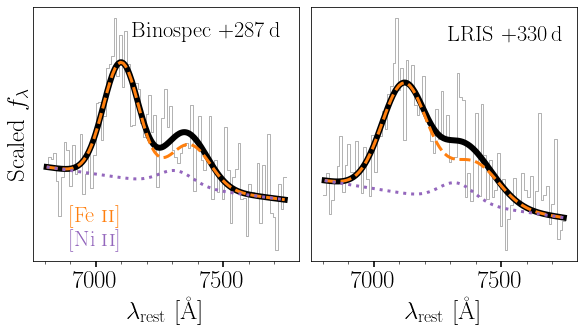

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4.5), constrained_layout=True, sharex=True)

colors = ["tab:orange", "tab:purple"]
plot_model(Spec_bino.line["[FeII/NiII]_7300"], Spec_bino.line["[FeII/NiII]_7300"].theta_MCMC, ax=ax[0], color=colors, ls=["--", ":"], lambda_0=7453)
plot_model(Spec_lris.line["[FeII/NiII]_7300"], Spec_lris.line["[FeII/NiII]_7300"].theta_MCMC, ax=ax[1], color=colors, ls=["--", ":"], lambda_0=7453)

ax[0].set_ylabel(r"$\mathrm{Scaled}\ f_\lambda$")
for a in ax:
    a.set_yticks([])
    a.set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")
    a.xaxis.set_major_locator(MultipleLocator(500))
    a.xaxis.set_minor_locator(MultipleLocator(100))

ax[0].text(7140, 1.5, r"$\mathrm{Binospec}\ $+$287\,\mathrm{d}$", fontsize=22.5)
ax[1].text(7290, 1.59, r"$\mathrm{LRIS}\ $+$330\,\mathrm{d}$", fontsize=22.5)

ax[0].text(6900, 0.49, r"$\mathrm{[Fe\ \textsc{ii}]}$", color=colors[0], fontsize=22.5)
ax[0].text(6900, 0.36, r"$\mathrm{[Ni\ \textsc{ii}]}$", color=colors[1], fontsize=22.5)

ax[0].tick_params(labelsize=25)
ax[1].tick_params(labelsize=25)

plt.savefig("../paper/figures/Fe_Ni.pdf")